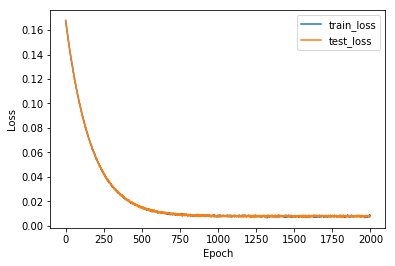

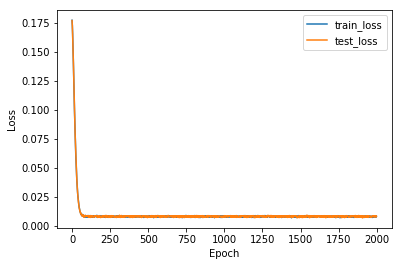

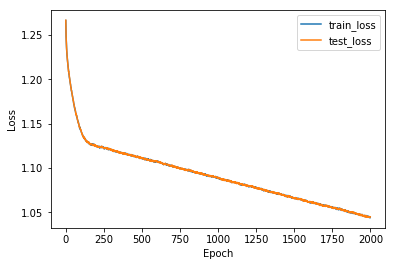

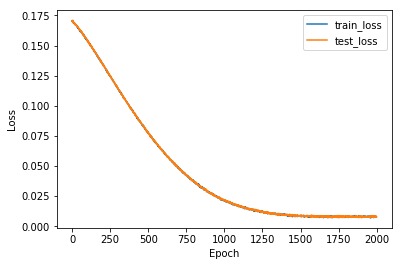

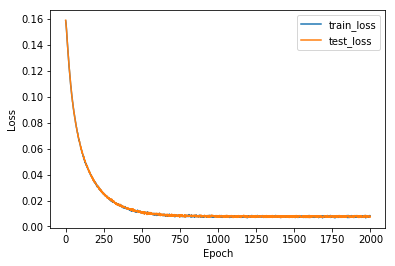

In [1]:
import numpy as np
from scipy.sparse import csr_matrix, hstack
import matplotlib.pyplot as plt
from sklearn import datasets,model_selection

def data_loader(file, n_features=None):
    if n_features==None:
        inputs,labels = datasets.load_svmlight_file(file)
    else:
        inputs,labels = datasets.load_svmlight_file(file,n_features=n_features)
    one = np.ones((inputs.shape[0],1))
    inputs = hstack( [inputs, csr_matrix(one)] ).toarray()
    labels = np.array(labels).reshape(inputs.shape[0],1)
    labels[labels==-1] = 0
    return inputs, labels

def gradient(X_train, Y_train, theta, C):
    index =  (1 - Y_train * X_train.dot(theta) < 0)
    Y = Y_train.copy()
    Y[index] = 0
    epsilon_gradient = -np.dot(X_train.transpose(), Y)  
    gradient = theta + C * epsilon_gradient
    return gradient

def loss_f(X, Y, theta, C=1):
    epsilon_loss = 1 - Y * X.dot(theta)
    epsilon_loss[epsilon_loss<0] = 0
    loss = 0.5 * np.dot(theta.transpose(), theta).sum() + C*epsilon_loss.sum()
    return loss/X.shape[0]

def train(X_train, Y_train, theta, learning_rate, C=0.8,optimizer=None, 
            optimizer_params=None):

    if optimizer == None:
            grad = gradient(X_train, Y_train, theta, C)
            theta -= learning_rate*grad
    elif optimizer == "NAG":
            Velocity = optimizer_params.setdefault('Velocity', np.zeros(theta.shape))
            momemtum = optimizer_params.setdefault('momemtum', 0.9)
            
            grad = gradient(X_train, Y_train, theta+ momemtum*Velocity, C)
            Velocity = momemtum*Velocity - learning_rate*grad
            theta += Velocity

            optimizer_params['Velocity'] = Velocity
    elif optimizer == "RMSprop":
            Velocity = optimizer_params.setdefault('Velocity', np.zeros(theta.shape))
            decay_rate = optimizer_params.setdefault('decay_rate', 0.9)
            epsilon = optimizer_params.setdefault('epsilon', 1e-7)

            grad = gradient(X_train, Y_train, theta, C)
            Velocity = decay_rate*Velocity + (1-decay_rate)*(grad**2)            
            theta -= learning_rate*grad/(np.sqrt(epsilon) + Velocity)
            
            optimizer_params['Velocity'] = Velocity
    elif optimizer == "Adadelta":
            Velocity = optimizer_params.setdefault('Velocity', np.zeros(theta.shape))
            update_accumulate = optimizer_params.setdefault('update_accumulate', np.zeros(theta.shape))
            decay_rate = optimizer_params.setdefault('decay_rate', 0.9)
            epsilon = optimizer_params.setdefault('epsilon', 1e-7)

            grad = gradient(X_train, Y_train, theta, C)
            Velocity = decay_rate*Velocity + (1-decay_rate)*(grad**2)
            step_update = -(np.sqrt(update_accumulate+epsilon))*grad/(np.sqrt(Velocity+epsilon))
            # step_update = - (np.sqrt(Velocity) + epsilon) * grad / (np.sqrt(Velocity) + epsilon)
            theta +=  step_update
            update_accumulate = decay_rate*update_accumulate + (1-decay_rate)*(step_update**2)
            
            optimizer_params['update_accumulate'] = update_accumulate
            optimizer_params['Velocity'] = Velocity
    elif optimizer == "Adam":
            Velocity = optimizer_params.setdefault('Velocity', np.zeros(theta.shape))
            S = optimizer_params.setdefault('S', np.zeros(theta.shape))
            beta1 =  optimizer_params.setdefault('beta1', 0.9)
            beta2 = optimizer_params.setdefault('beta2', 0.999)
            epsilon = optimizer_params.setdefault('epsilon', 1e-8)
            t=1
            grad = gradient(X_train, Y_train, theta,C)
            S = beta1*S + (1-beta1)*grad
            Velocity = beta2*Velocity + (1-beta2)*(grad**2)
            
            S_t = S/(1 - (beta1**t))
            Velocity_t = Velocity/(1- (beta2**t))
            step_update = - learning_rate * S_t/ (np.sqrt(Velocity_t) + epsilon)
            theta += step_update

            optimizer_params['S'] = S
            optimizer_params['Velocity'] = Velocity
        
    return theta



def get_batch(X, y ,mini_batch):
    index = np.random.randint(0,X.shape[0], size=mini_batch, dtype=int)
    return X[index,:], y[index]

def accuracy_f(X, Y, theta, threshold=0):
    Y_prediction = X.dot(theta)
    Y_prediction[Y_prediction<threshold] = -1
    Y_prediction[Y_prediction>=threshold] = 1

    classification = Y*Y_prediction
    classification[classification==-1] = 0
    accuracy = classification.sum()/classification.shape[0]
    return accuracy

def plot_loss(train_loss, test_loss):
    
    figure1 = plt.figure(1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(train_loss, label="train_loss")
    plt.plot(test_loss, label="test_loss")
    plt.legend(loc='upper right')

    plt.show()

def main(trian_file, test_file, 
        learning_rate=0.0003, 
        C=0.8,
        threshold=0, 
        mini_batch=64, 
        epoch=1000,     
        optimizer=None,
        optimizer_params=None):
    X_train, Y_train = data_loader(trian_file)
    X_test, Y_test = data_loader(test_file,X_train.shape[1]-1)
    theta = np.random.random((X_train.shape[1], 1))
    train_loss = []
    test_loss = []
    test_accuracy = []
    for episode in range(1,epoch):
        X_train_batch, Y_train_batch = get_batch(X_train, Y_train, mini_batch)
        theta = train(X_train_batch, Y_train_batch, theta,  learning_rate=learning_rate, C=0.8, optimizer=optimizer, optimizer_params=optimizer_params)
        
        loss = loss_f(X_train_batch, Y_train_batch, theta,C)
        train_loss.append(loss)
        
        X_test_batch, Y_test_batch = get_batch(X_test, Y_test, mini_batch)
        loss = loss_f(X_test_batch, Y_test_batch,theta,C)
        test_loss.append(loss)
        
    plot_loss(train_loss, test_loss )

if __name__ == "__main__":
    train_params = {
        'trian_file': 'a9a.txt',
        'test_file': 'a9a.t',
        'learning_rate': 0.003,
        'C': 0.009,
        'epoch': 2000,
        'threshold': 0,
        'mini_batch': 128,
        'optimizer': None
    }
    train_params_NAG = {
        'trian_file': 'a9a.txt',
        'test_file': 'a9a.t',
        'learning_rate': 0.003,
        'C': 0.009,
        'epoch': 2000,
        'threshold': 0,
        'mini_batch': 128,
        'optimizer': 'NAG'
    }
    train_params_RMSprop = {
        'trian_file': 'a9a.txt',
        'test_file': 'a9a.t',
        'learning_rate': 0.003,
        'C': 0.009,
        'epoch': 2000,
        'threshold': 0,
        'mini_batch': 128,
        'optimizer': 'RMSprop'
    }
    train_params_Adadelta = {
        'trian_file': 'a9a.txt',
        'test_file': 'a9a.t',
        'learning_rate': 0.003,
        'C': 0.009,
        'epoch': 2000,
        'threshold': 0,
        'mini_batch': 128,
        'optimizer': 'Adadelta'
    }
    train_params_Adam = {
        'trian_file': 'a9a.txt',
        'test_file': 'a9a.t',
        'learning_rate': 0.003,
        'C': 0.009,
        'epoch': 2000,
        'threshold': 0,
        'mini_batch': 128,
        'optimizer': 'Adam'
    }
    optimizer_params={
        'momemtum': 0.9,
        'decay_rate': 0.9,
        'epsilon':1e-8
    }
    main(**train_params, optimizer_params=optimizer_params)
    main(**train_params_NAG, optimizer_params=optimizer_params)
    main(**train_params_RMSprop, optimizer_params=optimizer_params)
    main(**train_params_Adadelta, optimizer_params=optimizer_params)
    main(**train_params_Adam, optimizer_params=optimizer_params)